In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

In [39]:
# Image size 256 and number of angles 90
df_other = pd.read_csv('Other-Implementations/logs/performance_log.csv')
df_metal = pd.read_csv('metal-logs/metal_performance_log.csv')

# Combine both datasets into one DataFrame
df_combined = pd.concat([df_other, df_metal], ignore_index=True)
df_combined = df_combined[(df_combined['ImageWidth']==256) & (df_combined['NumAngles']==90)]

# Group by ExecutionType, NumIterations, and calculate mean for both columns
grouped = df_combined.groupby(['ExecutionType', 'NumIterations'])[['ReconstructionTime_ms', 'FinalErrorNorm']].mean()

grouped.reset_index(inplace=True)
grouped = grouped[(grouped['NumIterations'] != 50) & (grouped['NumIterations'] <= 1000)]
df_other = df_other.dropna(subset=['FinalErrorNorm'])
grouped = grouped[grouped['FinalErrorNorm'] > 0]


# Pivot the data to create a single DataFrame
pivoted = grouped.pivot(index='NumIterations', columns=['ExecutionType'], values=['ReconstructionTime_ms', 'FinalErrorNorm'])

# Flatten the multi-level columns 
pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
pivoted = pivoted.rename_axis('Iterations', axis='index')
print(pivoted.columns)
pivoted = pivoted.rename(columns={
    'ReconstructionTime_ms_Sequential': 'Seq. (ms)',
    'ReconstructionTime_ms_openmp': 'OMP (ms)',
    'FinalErrorNorm_Sequential': 'Seq. Error Norm',
    'FinalErrorNorm_openmp': 'OMP Error Norm',
    'ReconstructionTime_ms_Metal': 'Metal (ms)',
    'FinalErrorNorm_Metal': 'Metal Error Norm'
})

# Define the new column order
new_column_order = [
    'Seq. (ms)',         
    'OMP (ms)',    
    'Metal (ms)',    
    'Seq. Error Norm',     
    'OMP Error Norm',        
    'Metal Error Norm'   
]

# Reorder the columns
pivoted = pivoted[new_column_order]

# Add speedup columns
pivoted['Speedup: OMP vs Seq'] = pivoted['Seq. (ms)'] / pivoted['OMP (ms)']
pivoted['Speedup: Metal vs Seq'] = pivoted['Seq. (ms)'] / pivoted['Metal (ms)']
pivoted['Speedup: Metal vs OMP'] = pivoted['OMP (ms)'] / pivoted['Metal (ms)']

# Calculate the global minimum and maximum across the selected columns
vmin = pivoted[['Speedup: OMP vs Seq', 'Speedup: Metal vs Seq', 'Speedup: Metal vs OMP']].min().min() 
vmax = pivoted[['Speedup: OMP vs Seq', 'Speedup: Metal vs Seq', 'Speedup: Metal vs OMP']].max().max()

# Apply the gradient with consistent vmin and vmax
styled_table = pivoted.style.format(precision=3)\
    .background_gradient(subset=['Speedup: OMP vs Seq', 'Speedup: Metal vs Seq', 'Speedup: Metal vs OMP'], cmap='Blues', vmin=vmin, vmax=vmax)
styled_table



Index(['ReconstructionTime_ms_Metal', 'ReconstructionTime_ms_Sequential',
       'ReconstructionTime_ms_openmp', 'FinalErrorNorm_Metal',
       'FinalErrorNorm_Sequential', 'FinalErrorNorm_openmp'],
      dtype='object')


,Seq. (ms),OMP (ms),Metal (ms),Seq. Error Norm,OMP Error Norm,Metal Error Norm,Speedup: OMP vs Seq,Speedup: Metal vs Seq,Speedup: Metal vs OMP
Iterations,,,,,,,,,
1,124.874,71.500,12.129,0.996,0.996,0.996,1.746,10.295,5.895
10,1224.541,732.940,69.416,0.965,0.965,0.965,1.671,17.641,10.559
100,18410.171,7677.612,521.556,0.808,0.808,0.808,2.398,35.299,14.721
500,129114.500,39806.083,2400.600,0.661,0.661,0.661,3.244,53.784,16.582
1000,226751.500,88153.525,4855.343,0.576,0.576,0.576,2.572,46.701,18.156


In [62]:
# Import data
df_other = pd.read_csv('Other-Implementations/logs/normalisation_log.csv')
df_metal = pd.read_csv('metal-logs/normalisation_log.csv')

df_combined = pd.concat([df_metal, df_other], ignore_index=True)

grouped = df_combined.groupby(['Type', 'ImageWidth', 'NumAngles', 'NumDetectors'])[['NormalisationTime']].mean().reset_index()

# Pivot the data to create a single DataFrame
pivoted = grouped.pivot(index=['ImageWidth', 'NumAngles', 'NumDetectors'], columns=['Type'], values='NormalisationTime')
pivoted.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivoted.columns.values]
pivoted.reset_index(inplace=True)

# Rename columns for clarity
pivoted = pivoted.rename(columns={
    'ImageWidth': 'Image Size',
    'NumAngles': 'Angles',
    'NumDetectors': 'Detectors',
    'Metal': 'Metal (ms)',
    'Sequential': 'Seq. (ms)',
    'OpenMP': 'OMP (ms)'
})
pivoted['Speedup: Metal vs Seq.'] = pivoted['Seq. (ms)'] / pivoted['Metal (ms)']
pivoted['Speedup: OMP vs Seq.'] = pivoted['Seq. (ms)'] / pivoted['OMP (ms)']
pivoted['Speedup: Metal vs OMP.'] = pivoted['OMP (ms)'] / pivoted['Metal (ms)']
pivoted['Sinogram Size'] = pivoted['Angles'] * pivoted['Detectors']
pivoted = pivoted[['Image Size', 'Angles', 'Detectors', 'Sinogram Size', 'Seq. (ms)','OMP (ms)', 'Metal (ms)', 'Speedup: OMP vs Seq.', 'Speedup: Metal vs Seq.', 'Speedup: Metal vs OMP.']]
styled_table = pivoted.style.format(precision=3)\
    .background_gradient(subset=['Speedup: Metal vs Seq.', 'Speedup: OMP vs Seq.', 'Speedup: Metal vs OMP.'], cmap='Blues')
styled_table


,Image Size,Angles,Detectors,Sinogram Size,Seq. (ms),OMP (ms),Metal (ms),Speedup: OMP vs Seq.,Speedup: Metal vs Seq.,Speedup: Metal vs OMP.
0,256,90,725,65250,0.790,0.740,5.681,1.067,0.139,0.130
1,256,180,725,130500,1.318,1.001,4.762,1.317,0.277,0.210
2,256,360,725,261000,2.426,1.462,5.532,1.659,0.439,0.264
3,512,90,1449,130410,2.919,0.750,4.748,3.892,0.615,0.158
4,512,180,1449,260820,2.447,1.314,6.565,1.862,0.373,0.200
5,512,360,1449,521640,4.424,2.164,5.114,2.045,0.865,0.423
6,1024,180,2897,521460,4.407,2.424,5.112,1.818,0.862,0.474
7,1024,360,2897,1042920,8.730,4.590,5.011,1.902,1.742,0.916
8,2048,360,5793,2085480,17.563,9.284,6.859,1.892,2.561,1.354
9,2048,720,5793,4170960,35.163,18.899,6.845,1.861,5.137,2.761


In [43]:
from scipy.stats import zscore

df_other = pd.read_csv('Other-Implementations/logs/performance_log.csv')
df_metal = pd.read_csv('metal-logs/metal_performance_log.csv')

# Drop rows with NAN values in ScanTime
df_other = df_other.dropna(subset=['ScanTime'])

def remove_outliers_zscore(df, column, threshold=3):
    z_scores = zscore(df[column])
    return df[abs(z_scores) < threshold]

# Remove outliers for ScanTime
df_metal = remove_outliers_zscore(df_metal, 'ScanTime')
df_other = remove_outliers_zscore(df_other, 'ScanTime')
df_combined = pd.concat([df_metal, df_other], ignore_index=True)
df_combined = df_combined[df_combined['NumAngles'] == 90]


# Group by Type, ImageWidth,NumAngles,NumDetectors
grouped = df_combined.groupby(['ExecutionType', 'ImageWidth', 'NumAngles', 'NumDetectors'])[['ScanTime']].mean().reset_index()
# Pivot the data to create a single DataFrame
pivoted = grouped.pivot(index=['ImageWidth', 'NumAngles', 'NumDetectors'], columns=['ExecutionType'], values='ScanTime')
pivoted.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivoted.columns.values]
pivoted.reset_index(inplace=True)

# Rename columns 
pivoted = pivoted.rename(columns={
    'ImageWidth': 'Image Size',
    'NumAngles': 'Angles',
    'NumDetectors': 'Detectors',
    'Metal': 'Metal Scan (ms)',
    'Sequential': 'Seq. Scan (ms)',
    'openmp': 'OMP Scan (ms)'
})
pivoted['Matrix Nonzero Elements'] = None 

# Add custom values for indices 0, 1, and 2
pivoted.loc[0, 'Matrix Nonzero Elements'] = 18737864  
pivoted.loc[1, 'Matrix Nonzero Elements'] = 74912415  
pivoted.loc[2, 'Matrix Nonzero Elements'] = 299563448
pivoted['Speedup: Metal vs Seq.'] = pivoted['Seq. Scan (ms)'] / pivoted['Metal Scan (ms)']
pivoted['Speedup: OMP vs Seq.'] = pivoted['Seq. Scan (ms)'] / pivoted['OMP Scan (ms)']
pivoted['Speedup: Metal vs OMP'] = pivoted['OMP Scan (ms)'] / pivoted['Metal Scan (ms)']

vmin = pivoted[['Speedup: OMP vs Seq.', 'Speedup: Metal vs Seq.', 'Speedup: Metal vs OMP']].min().min() 
vmax = pivoted[['Speedup: OMP vs Seq.', 'Speedup: Metal vs Seq.', 'Speedup: Metal vs OMP']].max().max()
pivoted = pivoted[['Image Size', 'Angles', 'Detectors', 'Matrix Nonzero Elements', 'Seq. Scan (ms)','OMP Scan (ms)', 'Metal Scan (ms)', 'Speedup: OMP vs Seq.', 'Speedup: Metal vs Seq.', 'Speedup: Metal vs OMP']]
styled_table = pivoted.style.format(precision=3)\
    .background_gradient(subset=['Speedup: Metal vs Seq.', 'Speedup: OMP vs Seq.', 'Speedup: Metal vs OMP'], cmap='Blues', vmin=vmin, vmax=vmax)
styled_table

,Image Size,Angles,Detectors,Matrix Nonzero Elements,Seq. Scan (ms),OMP Scan (ms),Metal Scan (ms),Speedup: OMP vs Seq.,Speedup: Metal vs Seq.,Speedup: Metal vs OMP
0,256,90,725,18737864,58.115,33.145,29.546,1.753,1.967,1.122
1,512,90,1449,74912415,238.268,109.627,64.384,2.173,3.701,1.703
2,1024,90,2897,299563448,1318.580,763.292,412.117,1.727,3.200,1.852


In [45]:
metal = pd.read_csv('metal-logs/relaxation_experiment_log.csv')
metal = metal[(metal['ExecutionType'] == 'Metal')]
metal = metal[(metal['NumIterations'] != 20000)]
metal = metal[(metal['RelaxationFactor'] <= 75)]
metal = metal[(metal['RelaxationFactor'] % 1 == 0)]
# drop factor of 3, 6, 15, 30
metal = metal[~metal['RelaxationFactor'].isin([3, 5, 6, 15, 30])]
# Group by NumIterations and relaxationFactor
grouped = metal.groupby(['NumIterations', 'RelaxationFactor'])[['FinalErrorNorm']].mean().reset_index()
pivoted = grouped.pivot(index='NumIterations', columns='RelaxationFactor', values='FinalErrorNorm')
pivoted.columns = [str(col) for col in pivoted.columns]
pivoted.reset_index(inplace=True)
pivoted = pivoted.rename(columns={'NumIterations': 'Iterations'})
styled_table = pivoted.style.format(precision=6)
styled_table

,Iterations,0.0,2.0,4.0,8.0,10.0,20.0,50.0,75.0
0,100,0.655804,0.749635,0.713795,0.604739,0.575547,0.475928,0.336338,0.283352
1,500,0.584945,0.575818,0.519068,0.370266,0.337758,0.250053,0.187105,0.175362
2,1000,0.561206,0.476315,0.414078,0.277379,0.254043,0.191738,0.162661,0.165618
3,5000,0.336937,0.254086,0.222335,0.193385,0.191975,0.163614,0.161011,0.160495
4,10000,0.254091,0.208006,0.196955,0.190769,0.190539,0.190153,0.189791,0.189642


In [50]:
metal = pd.read_csv('metal-logs/relaxation_experiment_log.csv')
metal = metal[(metal['ExecutionType'] == 'Metal') & (metal['NumAngles'] == 360)]
metal['ReconstructionTime_ms'] = pd.to_numeric(metal['ReconstructionTime_ms'], errors='coerce')
execution_time = metal.groupby('NumIterations')['ReconstructionTime_ms'].mean().reset_index()

# Group by NumIterations and relaxationFactor
grouped = metal.groupby(['NumIterations', 'RelaxationFactor'])[['FinalErrorNorm']].mean().reset_index()

# Pivot the data for FinalErrorNorm
pivoted = grouped.pivot(index='NumIterations', columns='RelaxationFactor', values='FinalErrorNorm')
pivoted.columns = [str(col) for col in pivoted.columns]
pivoted.reset_index(inplace=True)

pivoted = pivoted.rename(columns={'NumIterations': 'Iterations'})

# Compute the mean ReconstructionTime_ms grouped by NumIterations
execution_time = metal.groupby('NumIterations')['ReconstructionTime_ms'].mean().reset_index()
execution_time = execution_time.rename(columns={'NumIterations': 'Iterations', 'ReconstructionTime_ms': 'Time (ms)'})

# Merge the pivoted table with the execution time
pivoted = pivoted.merge(execution_time, on='Iterations')

# Style the table
styled_table = pivoted.style.format(precision=6)
styled_table

,Iterations,0.0,200.0,210.0,215.0,220.0,Time (ms)
0,100,0.822772,0.186113,0.182624,0.183205,2.867880,1693.397143
1,500,0.659305,0.112066,0.110798,0.110205,3062.760000,8703.780000
2,1000,0.573893,0.098171,0.097449,0.097109,18744200.000000,16769.585714


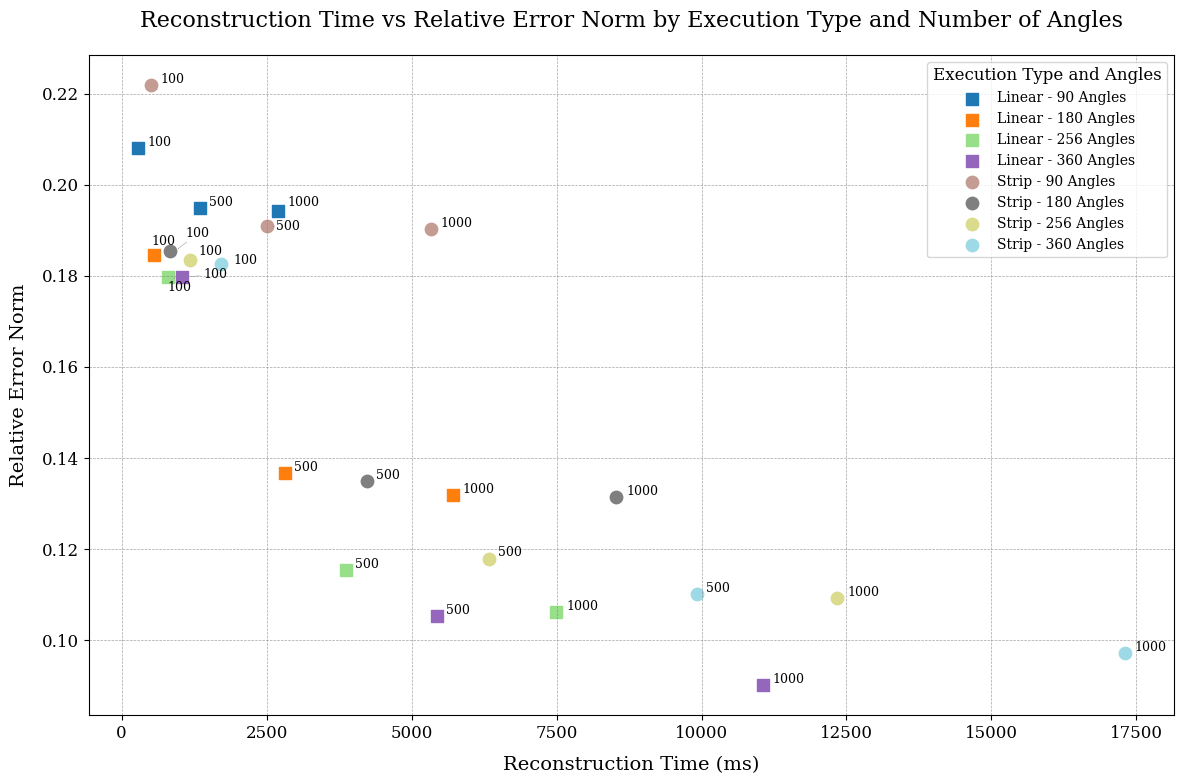

In [51]:
metal = pd.read_csv('metal-logs/relaxation_experiment_log.csv')

metal['ReconstructionTime_ms'] = pd.to_numeric(metal['ReconstructionTime_ms'], errors='coerce')
metal['FinalErrorNorm'] = pd.to_numeric(metal['FinalErrorNorm'], errors='coerce')

plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

metal = metal.dropna(subset=['ReconstructionTime_ms', 'FinalErrorNorm'])

# Filter for relevant data
metal = metal[metal['FinalErrorNorm'] < 1]
metal = metal[metal['NumIterations'] <= 1000]
metal = metal[(metal['ExecutionType'] == 'Metal') | (metal['ExecutionType'] == 'Metal-linear')]

metal['ExecutionType'] = metal['ExecutionType'].replace({'Metal': 'Strip'})
metal['ExecutionType'] = metal['ExecutionType'].replace({'Metal-linear': 'Linear'})

grouped = metal.groupby(['ExecutionType', 'NumIterations', 'RelaxationFactor', 'NumAngles'])[['FinalErrorNorm', 'ReconstructionTime_ms']].mean().reset_index()

# Find the best data for each ExecutionType, angle, and iteration count (minimum FinalErrorNorm)
best_data = grouped.loc[grouped.groupby(['ExecutionType', 'NumAngles', 'NumIterations'])['FinalErrorNorm'].idxmin()]

plt.figure(figsize=(12, 8))

# Define colors and markers for each ExecutionType
execution_types = best_data['ExecutionType'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(execution_types) * len(best_data['NumAngles'].unique())))
marker_mapping = {
    'Strip': 'o',
    'Linear': 's'
}

texts = []
color_index = 0
for execution_type, color, marker in zip(execution_types, colors, marker_mapping.values()):
    subset = best_data[best_data['ExecutionType'] == execution_type]
    angles = subset['NumAngles'].unique()
    for angle in angles:
        angle_subset = subset[subset['NumAngles'] == angle]
        marker = marker_mapping.get(execution_type, 'o')
        color = colors[color_index]
        color_index += 1
        plt.scatter(angle_subset['ReconstructionTime_ms'], angle_subset['FinalErrorNorm'], 
                    label=f'{execution_type} - {int(angle)} Angles', color=color, marker=marker, s=80)
        for _, row in angle_subset.iterrows():
            texts.append(plt.text(row['ReconstructionTime_ms'] + 100, 
                                row['FinalErrorNorm'], 
                                f"{int(row['NumIterations'])}", fontsize=9, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.3))

plt.xlabel('Reconstruction Time (ms)', fontsize=14, labelpad=10)
plt.ylabel('Relative Error Norm', fontsize=14, labelpad=10)
plt.title('Reconstruction Time vs Relative Error Norm by Execution Type and Number of Angles', fontsize=16, pad=20)
plt.legend(title='Execution Type and Angles', title_fontsize=12, fontsize=10, loc='upper right', frameon=True)
plt.grid(True, which="both", ls="--", linewidth=0.5, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

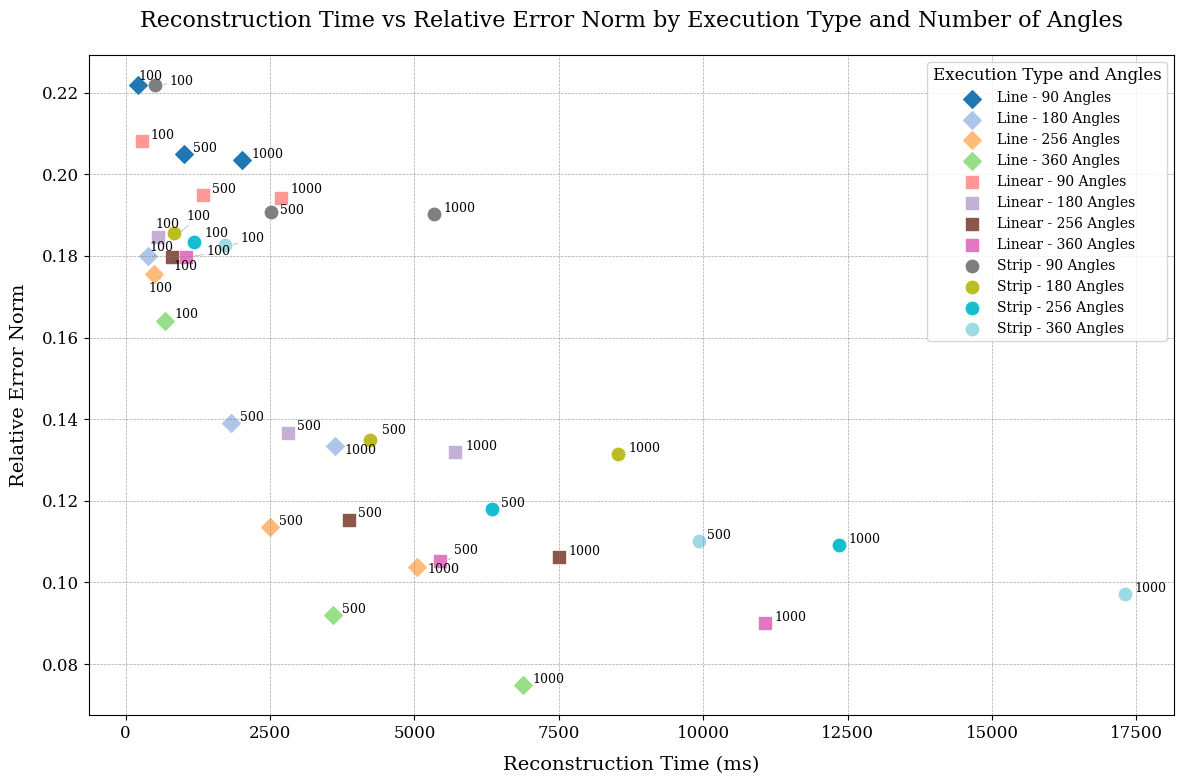

In [53]:
metal = pd.read_csv('metal-logs/relaxation_experiment_log.csv')

metal['ReconstructionTime_ms'] = pd.to_numeric(metal['ReconstructionTime_ms'], errors='coerce')
metal['FinalErrorNorm'] = pd.to_numeric(metal['FinalErrorNorm'], errors='coerce')

plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

metal = metal.dropna(subset=['ReconstructionTime_ms', 'FinalErrorNorm'])

metal = metal[metal['FinalErrorNorm'] < 1]
metal = metal[metal['NumIterations'] <= 1000]
metal = metal[(metal['ExecutionType'] == 'Metal') | (metal['ExecutionType'] == 'Metal-linear') | (metal['ExecutionType'] == 'Metal-line')]

metal['ExecutionType'] = metal['ExecutionType'].replace({'Metal': 'Strip'})
metal['ExecutionType'] = metal['ExecutionType'].replace({'Metal-linear': 'Linear'})
metal['ExecutionType'] = metal['ExecutionType'].replace({'Metal-line': 'Line'})

grouped = metal.groupby(['ExecutionType', 'NumIterations', 'RelaxationFactor', 'NumAngles'])[['FinalErrorNorm', 'ReconstructionTime_ms']].mean().reset_index()

# Find the best data for each ExecutionType, angle, and iteration count (minimum FinalErrorNorm)
best_data = grouped.loc[grouped.groupby(['ExecutionType', 'NumAngles', 'NumIterations'])['FinalErrorNorm'].idxmin()]

plt.figure(figsize=(12, 8))

execution_types = best_data['ExecutionType'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(execution_types) * len(best_data['NumAngles'].unique())))
marker_mapping = {
    'Strip': 'o',
    'Linear': 's',
    'Line': 'D'
}

texts = []
color_index = 0
for execution_type, color, marker in zip(execution_types, colors, marker_mapping.values()):
    subset = best_data[best_data['ExecutionType'] == execution_type]
    angles = subset['NumAngles'].unique()
    for angle in angles:
        angle_subset = subset[subset['NumAngles'] == angle]
        marker = marker_mapping.get(execution_type, 'o')
        color = colors[color_index]
        color_index += 1
        plt.scatter(angle_subset['ReconstructionTime_ms'], angle_subset['FinalErrorNorm'], 
                    label=f'{execution_type} - {int(angle)} Angles', color=color, marker=marker, s=80)
        for _, row in angle_subset.iterrows():
            texts.append(plt.text(row['ReconstructionTime_ms'] + 100,  
                                row['FinalErrorNorm'],  
                                f"{int(row['NumIterations'])}", fontsize=9, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.3))

plt.xlabel('Reconstruction Time (ms)', fontsize=14, labelpad=10)
plt.ylabel('Relative Error Norm', fontsize=14, labelpad=10)
plt.title('Reconstruction Time vs Relative Error Norm by Execution Type and Number of Angles', fontsize=16, pad=20)
plt.legend(title='Execution Type and Angles', title_fontsize=12, fontsize=10, loc='upper right', frameon=True)
plt.grid(True, which="both", ls="--", linewidth=0.5, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

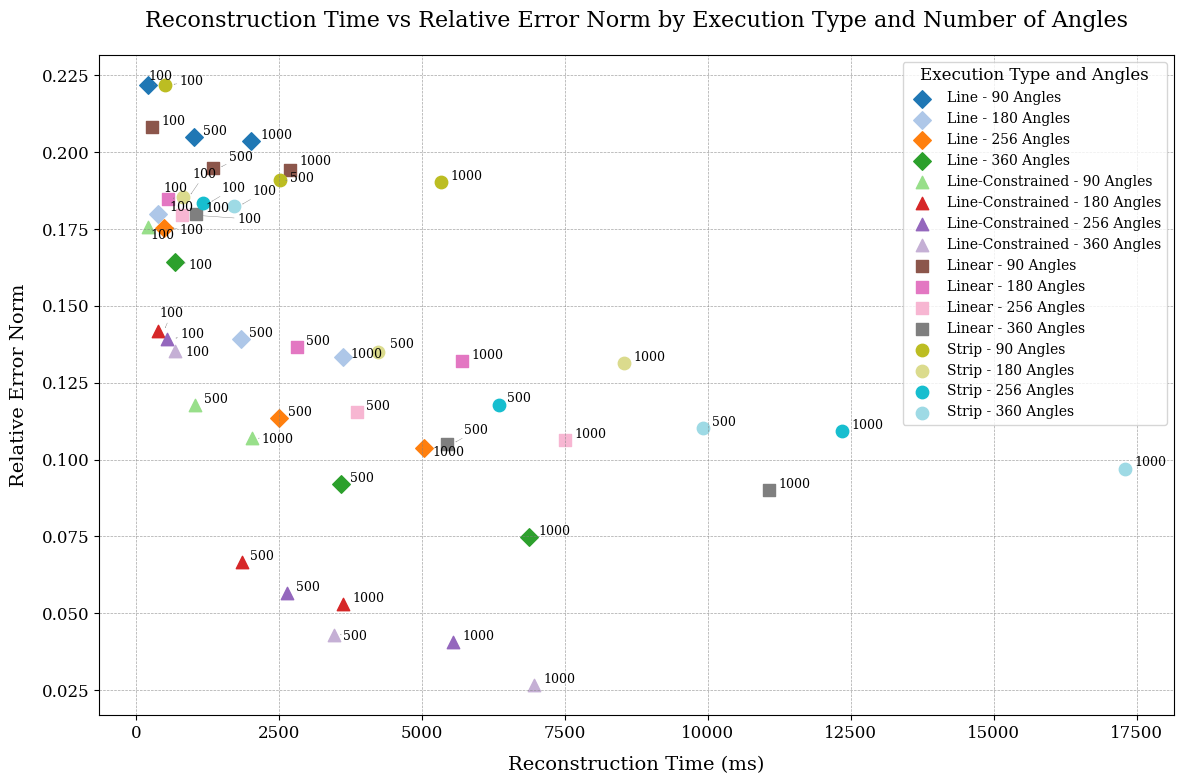

In [57]:
metal = pd.read_csv('metal-logs/relaxation_experiment_log.csv')

metal['ReconstructionTime_ms'] = pd.to_numeric(metal['ReconstructionTime_ms'], errors='coerce')
metal['FinalErrorNorm'] = pd.to_numeric(metal['FinalErrorNorm'], errors='coerce')

plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

metal = metal.dropna(subset=['ReconstructionTime_ms', 'FinalErrorNorm'])

metal = metal[metal['FinalErrorNorm'] < 1]
metal = metal[metal['NumIterations'] <= 1000]
metal = metal[(metal['ExecutionType'] == 'Metal-line-constrained') | (metal['ExecutionType'] == 'Metal') | (metal['ExecutionType'] == 'Metal-linear') | (metal['ExecutionType'] == 'Metal-line')]

metal['ExecutionType'] = metal['ExecutionType'].replace({'Metal': 'Strip'})
metal['ExecutionType'] = metal['ExecutionType'].replace({'Metal-linear': 'Linear'})
metal['ExecutionType'] = metal['ExecutionType'].replace({'Metal-line': 'Line'})
metal['ExecutionType'] = metal['ExecutionType'].replace({'Metal-line-constrained': 'Line-Constrained'})

grouped = metal.groupby(['ExecutionType', 'NumIterations', 'RelaxationFactor', 'NumAngles'])[['FinalErrorNorm', 'ReconstructionTime_ms']].mean().reset_index()

# Find the best data for each ExecutionType, angle, and iteration count (minimum FinalErrorNorm)
best_data = grouped.loc[grouped.groupby(['ExecutionType', 'NumAngles', 'NumIterations'])['FinalErrorNorm'].idxmin()]

plt.figure(figsize=(12, 8))

execution_types = best_data['ExecutionType'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(execution_types) * len(best_data['NumAngles'].unique())))
marker_mapping = {
    'Strip': 'o',
    'Linear': 's',
    'Line': 'D',
    'Line-Constrained': '^'
}

texts = []
color_index = 0
for execution_type, color, marker in zip(execution_types, colors, marker_mapping.values()):
    subset = best_data[best_data['ExecutionType'] == execution_type]
    angles = subset['NumAngles'].unique()
    for angle in angles:
        angle_subset = subset[subset['NumAngles'] == angle]
        marker = marker_mapping.get(execution_type, 'o')
        color = colors[color_index]
        color_index += 1
        plt.scatter(angle_subset['ReconstructionTime_ms'], angle_subset['FinalErrorNorm'], 
                    label=f'{execution_type} - {int(angle)} Angles', color=color, marker=marker, s=80)
        for _, row in angle_subset.iterrows():
            texts.append(plt.text(row['ReconstructionTime_ms'] + 100,  
                                row['FinalErrorNorm'], 
                                f"{int(row['NumIterations'])}", fontsize=9, color='black'))


adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.3))

plt.xlabel('Reconstruction Time (ms)', fontsize=14, labelpad=10)
plt.ylabel('Relative Error Norm', fontsize=14, labelpad=10)
plt.title('Reconstruction Time vs Relative Error Norm by Execution Type and Number of Angles', fontsize=16, pad=20)
plt.legend(title='Execution Type and Angles', title_fontsize=12, fontsize=10, loc='upper right', frameon=True)
plt.grid(True, which="both", ls="--", linewidth=0.5, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

In [61]:
# Log best reconstructions across all implementations
df_other = pd.read_csv('Other-Implementations/logs/performance_log.csv')
df_metal = pd.read_csv('metal-logs/relaxation_experiment_log.csv')

df_metal['ReconstructionTime_ms'] = pd.to_numeric(df_metal['ReconstructionTime_ms'], errors='coerce')
df_metal['FinalErrorNorm'] = pd.to_numeric(df_metal['FinalErrorNorm'], errors='coerce')

df_other = df_other[(df_other['ExecutionType'] == 'openmp-enhanced') | (df_other['ExecutionType'] == 'Sequential-enhanced')]
df_metal = df_metal[(df_metal['ExecutionType'] == 'Metal-line-constrained') & (df_metal['RelaxationFactor'] == 350)]
df_combined = pd.concat([df_other, df_metal], ignore_index=True)
df_combined = df_combined[(df_combined['ImageWidth']==256) & (df_combined['NumAngles']==360)]

# Group by ExecutionType, NumIterations, and Source, and calculate mean for both columns
grouped = df_combined.groupby(['ExecutionType', 'NumIterations'])[['ReconstructionTime_ms', 'FinalErrorNorm']].mean()

grouped.reset_index(inplace=True)
grouped = grouped[(grouped['NumIterations'] != 50) & (grouped['NumIterations'] <= 1000)]
df_other = df_other.dropna(subset=['FinalErrorNorm'])
grouped = grouped[grouped['FinalErrorNorm'] > 0]

pivoted = grouped.pivot(index='NumIterations', columns=['ExecutionType'], values=['ReconstructionTime_ms', 'FinalErrorNorm'])

pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
pivoted = pivoted.rename_axis('Iterations', axis='index')

pivoted = pivoted.rename(columns={
    'ReconstructionTime_ms_Sequential-enhanced': 'Seq. (ms)',
    'ReconstructionTime_ms_openmp-enhanced': 'OMP (ms)',
    'FinalErrorNorm_Sequential-enhanced': 'Seq. Error Norm',
    'FinalErrorNorm_openmp-enhanced': 'OMP Error Norm',
    'ReconstructionTime_ms_Metal-line-constrained': 'Metal (ms)',
    'FinalErrorNorm_Metal-line-constrained': 'Metal Error Norm'
})

# Define the new column order
new_column_order = [
    'Seq. (ms)',         
    'OMP (ms)',    
    'Metal (ms)',    
    'Seq. Error Norm',     
    'OMP Error Norm',        
    'Metal Error Norm'   
]

pivoted = pivoted[new_column_order]

pivoted['OMP vs Seq'] = pivoted['Seq. (ms)'] / pivoted['OMP (ms)']
pivoted['Metal vs Seq'] = pivoted['Seq. (ms)'] / pivoted['Metal (ms)']
pivoted['Metal vs OMP'] = pivoted['OMP (ms)'] / pivoted['Metal (ms)']

# Calculate the global minimum and maximum across the selected columns
vmin = pivoted[['OMP vs Seq', 'Metal vs Seq', 'Metal vs OMP']].min().min() 
vmax = pivoted[['OMP vs Seq', 'Metal vs Seq', 'Metal vs OMP']].max().max()

# Apply the gradient with consistent vmin and vmax
styled_table = pivoted.style.format(precision=3)\
    .background_gradient(subset=['OMP vs Seq', 'Metal vs Seq', 'Metal vs OMP'], cmap='Blues', vmin=vmin, vmax=vmax)
styled_table

,Seq. (ms),OMP (ms),Metal (ms),Seq. Error Norm,OMP Error Norm,Metal Error Norm,OMP vs Seq,Metal vs Seq,Metal vs OMP
Iterations,,,,,,,,,
100,20650.500,14416.617,685.050,0.135,0.135,0.135,1.432,30.145,21.045
500,104291.000,74800.825,3469.415,0.043,0.043,0.043,1.394,30.060,21.560
1000,208790.000,150291.000,6952.087,0.027,0.027,0.027,1.389,30.033,21.618
